In [1]:
import torch
import torch.nn as nn
import torch

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset

## 기본 transformer 구조

In [2]:
class Transformer(nn.Module):
    def __init__(self,num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_lyaers, dropout_p,):
        super().__init__()

        #Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

    def forward(self):
        pass

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self,dim_model,dropout_p,max_len):
        super().__init__()

        # dropout
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0,max_len, dtype=torch.float).view(-1,1) # 한줄로 길게 뽑음. 0,1,2,3 ...

        division_term = torch.exp(torch.arange(0,dim_model,2).float() * (-math.log(10000.0))/dim_model) # 10000^(2i/dim_model)

        pos_encoding[:,0::2] = torch.sin(positions_list * division_term) # 짝수번째 항
        pos_encoding[:,1::2] = torch.cos(positions_list * division_term) # 홀수번째 항

        # Saving buffer (same as parameter without gradients needed)
        # GPU 사용 가능, optim 업데이트 x
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0,1)
        self.register_buffer('pos_encoding',pos_encoding)
    
    def forward(self,token_embedding:torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0),:])


In [14]:
class Transformer(nn.Module):
    # constructor
    def __init__(self,num_tokens,dim_model,num_heads,num_encoder_layers,num_decoder_layers,dropout_p,):
        super().__init__()

        # INFO
        self.model_type = 'Transformer'
        self.dim_model=dim_model

        # Layers
        self.positional_encoder = PositionalEncoding(dim_model=dim_model,dropout_p=dropout_p,max_len=5000)
        self.embedding = nn.Embedding(num_tokens,dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model,num_tokens)

    def forward(self,src,tgt,tgt_mask=None, src_pad_mask=None,tgt_pad_mask=None):

        # SRc, Tgt size는 반드시 (batch, src sequence length)이어야 한다.
        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.transpose(1,0)
        tgt = tgt.transpose(1,0)

        # Transformer blocks - Out size = (sequence length , batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask,tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self,size) -> torch.tensor:
        mask = torch.tril(torch.ones(size,size) == 1) # Lower triangular matrix 
        mask = mask.float()
        mask = mask.masked_fill(mask == 0,float('-inf')) # masking zeros to -inf
        mask = mask.masked_fill(mask ==1, float(0.0)) # ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor,pad_token: int) -> torch.tensor: #?
        return (matrix == pad_token)


In [29]:
 mask = torch.tril(torch.ones(3,3))# Lower triangular matrix 
 mask

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [28]:
 mask = torch.tril(torch.ones(3,3) == 1) # Lower triangular matrix 
 mask

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

In [15]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


In [16]:
def train_loop(model, opt, loss_fn,dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X,y = batch[:,0], batch[:,1]
        X,y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # tgt를 1씩 이동시키며 <SOS>를 사용해 pos 1 에서의 토큰 예측
        y_input = y[:,:-1]
        y_expected = y[:,1:]

        # 마스킹 정보 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input, tgt_mask를 전달해 training
        pred = model(X,y_input,tgt_mask)

        # Permute를 수행해 batch size가 처음으로 오도록
        pred = pred.permute(1,2,0)
        loss = loss_fn(pred,y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [17]:
def validation_loop(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X,y = batch[:,0], batch[:,1]
            X,y = torch.tensor(X, dtype=torch.long, device=device),torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:,:-1]
            y_expected = y[:,1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X,y_input,tgt_mask)

            pred = pred.permute(1,2,0)
            loss = loss_fn(pred,y_expected)
            total_loss += loss.detach().item()

    return total_loss / len(dataloader)

In [26]:
def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # for plotting
    train_loss_list, validation_loss_list = [],[]

    print('Traing and Validating model')
    for epoch in range(epochs):
        print('-'*30,f'Epoch {epoch +1}', '-'*30)

        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]

        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f'training loss: {train_loss:.4f}')
        print(f'validation loss: {validation_loss:.4f}')
        print()

    return train_loss_list, validation_loss_list

train_loss_list, validation_loss_list = fit(model,opt,loss_fn,train_dataloader,val_dataloader,10)

Traing and Validating model
------------------------------ Epoch 1 ------------------------------
training loss: 0.5563
validation loss: 0.4256

------------------------------ Epoch 2 ------------------------------
training loss: 0.4343
validation loss: 0.3988

------------------------------ Epoch 3 ------------------------------
training loss: 0.4125
validation loss: 0.3797

------------------------------ Epoch 4 ------------------------------
training loss: 0.3954
validation loss: 0.3599

------------------------------ Epoch 5 ------------------------------
training loss: 0.3773
validation loss: 0.3369

------------------------------ Epoch 6 ------------------------------
training loss: 0.3591
validation loss: 0.3067

------------------------------ Epoch 7 ------------------------------
training loss: 0.3380
validation loss: 0.2783

------------------------------ Epoch 8 ------------------------------
training loss: 0.3180
validation loss: 0.2523

------------------------------ Epoch

In [31]:
import matplotlib.pyplot as plt

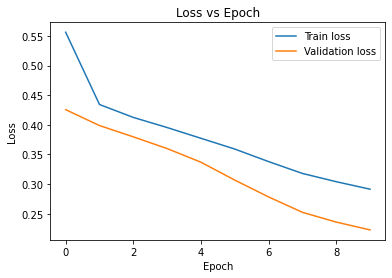

In [33]:
plt.plot(train_loss_list, label = 'Train loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [34]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    model.eval()

    y_input = torch.tensor([[SOS_token]], dtype=torch.long,device=device)
    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Get source mask
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        pred = model(input_sequence,y_input, tgt_mask)

        next_item = pred.topk(1)[1].view(-1)[-1].item() # 가장 확률이 높음
        next_item = torch.tensor([[next_item]], device=device)

        # 이전 input과 예측 best 단어 열 기준 concat
        y_input = torch.cat((y_input,next_item),dim=1)

        # 문장의 끝에 도달하면 모델 예측 중지
        if next_item.view(-1).item() == EOS_token:
            break
    return y_input.view(-1).tolist()




In [35]:
# 문장시작:2, 문장 끝:3
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)
]

In [36]:
for idx, example in enumerate(examples):
    result = predict(model,example)
    print(f'Example {idx}')
    print(f'Input: {example.view(-1).tolist()[1:-1]}')
    print(f'Continuation: {result[1:-1]}')
    print()

Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

Example 5
Input: [0, 1]
Continuation: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

